In [5]:
import pandas as pd
import numpy as np
import os, tarfile, shutil
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from dateutil.tz import gettz

from prophet import Prophet
from ortools.sat.python import cp_model



In [12]:
TZ = "America/New_York"

# Week you’re scheduling
week_start = pd.Timestamp("2025-11-03 00:00", tz=TZ)  # Monday start
week_end   = week_start + pd.Timedelta(days=7)

# Fixed events (cannot move)
fixed_events = pd.DataFrame([
    # id, start, end, label
    ("class-os", "2025-11-03 12:50", "2025-11-03 14:45", "OS Class"),
    ("team-sync", "2025-11-04 18:30", "2025-11-04 19:30", "Team Sync"),
    ("iprd", "2025-11-06 13:00", "2025-11-06 14:30", "Profs Mtg"),
], columns=["id","start","end","label"])
fixed_events["start"] = pd.to_datetime(fixed_events["start"]).dt.tz_localize(TZ)
fixed_events["end"]   = pd.to_datetime(fixed_events["end"]).dt.tz_localize(TZ)

# Dynamic tasks to schedule (movable)
tasks = pd.DataFrame([
    # id, label, duration_hours, priority (1-3), latest (optional deadline)
    ("dw1", "Deep Work: Project", 3, 3, "2025-11-07 17:00"),
    ("study1", "Study: OS", 2, 2, "2025-11-08 23:59"),
    ("gym", "Gym", 1, 1, None),
], columns=["id","label","dur_h","priority","latest"])
tasks["latest"] = tasks["latest"].apply(lambda x: pd.to_datetime(x).tz_localize(TZ) if pd.notnull(x) else None)

# User preferences (simple, can become regressors)
PREF = {
    "slot_minutes": 60,          # choose 30 or 60
    "avoid_evenings_after": 20,  # 24h clock
    "prefer_morning_start": 8,
    "prefer_morning_end": 11,
    "weekend_ok": False,
}

In [13]:
# Build slot grid
slot_minutes = PREF["slot_minutes"]
slots = pd.DataFrame({
    "ds": pd.date_range(week_start, week_end, freq=f"{slot_minutes}min", inclusive="left")
})
slots["hour"] = slots["ds"].dt.hour
slots["weekday"] = slots["ds"].dt.weekday  # 0=Mon
slots["is_weekend"] = (slots["weekday"]>=5).astype(int)

# Block fixed events
blocked = np.zeros(len(slots), dtype=bool)
for _,r in fixed_events.iterrows():
    mask = (slots["ds"] >= r["start"]) & (slots["ds"] < r["end"])
    blocked |= mask.values
if not PREF["weekend_ok"]:
    blocked |= (slots["is_weekend"]==1).values


In [14]:
def compute_meeting_density(slots_df, fixed_df, window_min=90):
    """Fraction (0..1) of minutes occupied by fixed events in +/- window around each slot."""
    if fixed_df.empty:
        return np.zeros(len(slots_df))
    half = pd.Timedelta(minutes=window_min)
    vals = []
    for t in slots_df["ds"]:
        s, e = t - half, t + half
        overlap_min = 0.0
        for _, r in fixed_df.iterrows():
            st, en = r["start"], r["end"]
            if en <= s or st >= e:
                continue
            overlap_min += (min(en, e) - max(st, s)).total_seconds()/60.0
        vals.append(overlap_min/(2*window_min))
    return np.array(vals)

def add_deadline_pressure(df, tasks_df, window_days=3):
    """Max ramp (0..1) across tasks as deadlines approach within window_days."""
    out = df.copy()
    out["deadline_pressure"] = 0.0
    if len(tasks_df):
        for _, t in tasks_df.iterrows():
            ddl = t.get("latest")
            if pd.notnull(ddl):
                ddl = pd.to_datetime(ddl)
                days_left = (ddl - out["ds"]).dt.total_seconds()/86400
                out["deadline_pressure"] = np.maximum(
                    out["deadline_pressure"],
                    np.clip((window_days - days_left)/window_days, 0, 1)
                )
    return out

def add_regressors(df, fixed_df, tasks_df):
    out = df.copy()
    # keep using tz-aware datetimes here; we'll strip tz only for Prophet below
    ds = out["ds"]
    out["prefer_morning"] = ((ds.dt.hour >= PREF["prefer_morning_start"]) &
                             (ds.dt.hour <= PREF["prefer_morning_end"])).astype(int)
    out["avoid_late"] = (ds.dt.hour >= PREF["avoid_evenings_after"]).astype(int)
    out["is_weekend"] = (ds.dt.weekday >= 5).astype(int)
    out["meeting_density"] = compute_meeting_density(out, fixed_df, window_min=90)
    out = add_deadline_pressure(out, tasks_df, window_days=3)
    return out


In [15]:
# Minimal cold-start history (4 weeks of priors)
hist_start = week_start - pd.Timedelta(days=28)
hist_end   = week_start
hist = pd.DataFrame({"ds": pd.date_range(hist_start, hist_end, freq=f"{slot_minutes}min", inclusive="left")})
hist["hour"] = hist["ds"].dt.hour
hist["weekday"] = hist["ds"].dt.weekday
hist["prefer_morning"] = ((hist["hour"]>=PREF["prefer_morning_start"]) & (hist["hour"]<=PREF["prefer_morning_end"])).astype(int)
hist["avoid_late"] = (hist["hour"]>=PREF["avoid_evenings_after"]).astype(int)
hist["is_weekend"] = (hist["weekday"]>=5).astype(int)
base = 0.45 + 0.20*hist["prefer_morning"] - 0.15*hist["avoid_late"] - 0.15*hist["is_weekend"]
hist["y"] = np.clip(base, 0.05, 0.95)

# Prophet: extend with new regressors (MEETING + DEADLINE) and fit (naive timestamps)
hist_reg = add_regressors(hist[["ds","y"]].copy(), fixed_events, tasks)
hist_reg["ds"] = pd.to_datetime(hist_reg["ds"]).dt.tz_localize(None)

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode="additive",
    uncertainty_samples=0,   # faster & avoids heavy draws
)
for reg in ["prefer_morning","avoid_late","is_weekend","meeting_density","deadline_pressure"]:
    m.add_regressor(reg)

m.fit(hist_reg.rename(columns={"y": "y"}))

future = add_regressors(slots[["ds"]].copy(), fixed_events, tasks)
future["ds"] = pd.to_datetime(future["ds"]).dt.tz_localize(None)
forecast = m.predict(future)
slots["utility_base"] = forecast["yhat"].clip(0, 1).values

18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:23 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Task-aware utility tweaks
def task_slot_utility(task_row, slot_row):
    u = float(slot_row.utility_base)
    label = str(task_row.label).lower()
    hour = int(slot_row.hour)
    # Deep work daytime bias
    if "deep work" in label and not (8 <= hour <= 17):
        u *= 0.85
    # Gym morning bias
    if "gym" in label:
        u *= 1.3 if 6 <= hour <= 9 else 0.8
    return max(0.0, min(1.0, u))


# Helper to check if a start index is feasible for a task
def feasible_starts(task, blocked_mask):
    dur_slots = int(task.dur_h * 60 // slot_minutes)
    cand = []
    for i in range(len(slots) - dur_slots + 1):
        # any blocked inside?
        if blocked_mask[i:i+dur_slots].any():
            continue
        # deadline check (end <= latest) if provided
        if pd.notnull(task.latest):
            end_time = slots.loc[i + dur_slots - 1, "ds"] + pd.Timedelta(minutes=slot_minutes)
            if end_time > task.latest:
                continue
        cand.append(i)
    return cand

# Extra constraint settings
BUFFER_MIN = 60               # gap between tasks (minutes)
MAX_HOURS_PER_DAY = 4         # cap scheduled hours/day
buffer_slots = BUFFER_MIN // slot_minutes
max_slots_per_day = MAX_HOURS_PER_DAY * (60 // slot_minutes)

model = cp_model.CpModel()
x = {}  # x[(t_idx, start_idx)] = 1 if task t starts at start_idx

dur_slots_list = []
feasible_by_task = []
for t_idx, task in tasks.iterrows():
    dur_slots = int(task.dur_h * 60 // slot_minutes)
    dur_slots_list.append(dur_slots)
    cand = feasible_starts(task, blocked)
    feasible_by_task.append(cand)
    for i in cand:
        x[(t_idx, i)] = model.NewBoolVar(f"x_t{t_idx}_i{i}")

# Each task starts exactly once (allowing no-solution tasks to drop would require a dummy var)
for t_idx, task in tasks.iterrows():
    cand = feasible_by_task[t_idx]
    if cand:
        model.Add(sum(x[(t_idx, i)] for i in cand) == 1)

# No overlaps
for s in range(len(slots)):
    covers = []
    for t_idx, task in tasks.iterrows():
        dur = dur_slots_list[t_idx]
        for i in feasible_by_task[t_idx]:
            if i <= s < i + dur:
                covers.append(x[(t_idx, i)])
    if covers:
        model.Add(sum(covers) <= 1)

# Buffer between tasks
for t1_idx, _ in tasks.iterrows():
    dur1 = dur_slots_list[t1_idx]
    for t2_idx, _ in tasks.iterrows():
        if t1_idx >= t2_idx:
            continue
        dur2 = dur_slots_list[t2_idx]
        for i in feasible_by_task[t1_idx]:
            for j in feasible_by_task[t2_idx]:
                too_close = not (j >= i + dur1 + buffer_slots or i >= j + dur2 + buffer_slots)
                if too_close:
                    model.AddBoolOr([x[(t1_idx,i)].Not(), x[(t2_idx,j)].Not()])

# Daily cap (approx): limit number of task starts whose blocks touch a day
slot_dates = slots["ds"].dt.date.values
for d in np.unique(slot_dates):
    starts_touching_day = []
    for t_idx, task in tasks.iterrows():
        dur = dur_slots_list[t_idx]
        for i in feasible_by_task[t_idx]:
            if any(slots.iloc[i+k]["ds"].date() == d for k in range(dur)):
                starts_touching_day.append(x[(t_idx,i)])
    if starts_touching_day:
        model.Add(sum(starts_touching_day) <= max_slots_per_day)

# Objective: maximize total (utility × priority)
objective_terms = []
for t_idx, task in tasks.iterrows():
    dur = dur_slots_list[t_idx]
    for i in feasible_by_task[t_idx]:
        u = 0.0
        for k in range(dur):
            u += task_slot_utility(task, slots.iloc[i+k])
        objective_terms.append(u * float(task.priority) * x[(t_idx, i)])
model.Maximize(sum(objective_terms))

solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 10
_ = solver.Solve(model)

scheduled = []
for t_idx, task in tasks.iterrows():
    dur = dur_slots_list[t_idx]
    for i in feasible_by_task[t_idx]:
        if (t_idx, i) in x and solver.Value(x[(t_idx, i)]) == 1:
            start = slots.loc[i, "ds"]
            end = slots.loc[i + dur - 1, "ds"] + pd.Timedelta(minutes=slot_minutes)
            scheduled.append((task.id, task.label, start, end, task.priority))
scheduled_df = pd.DataFrame(scheduled, columns=["id","label","start","end","priority"]).sort_values("start")

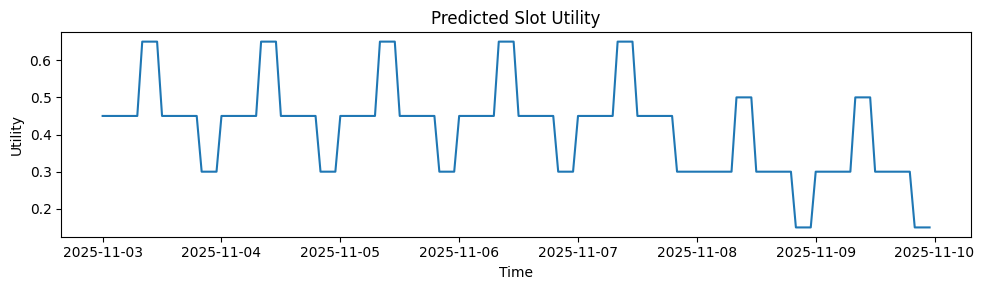

,id,label,start,end,priority
2,gym,Gym,2025-11-05 08:00:00-05:00,2025-11-05 09:00:00-05:00,1
1,study1,Study: OS,2025-11-05 10:00:00-05:00,2025-11-05 12:00:00-05:00,2
0,dw1,Deep Work: Project,2025-11-06 08:00:00-05:00,2025-11-06 11:00:00-05:00,3


In [17]:
# Plots / output
plt.figure(figsize=(10,3))
plt.plot(slots["ds"], slots["utility_base"])
plt.title("Predicted Slot Utility")
plt.xlabel("Time"); plt.ylabel("Utility"); plt.tight_layout(); plt.show()

scheduled_df

In [18]:
#load data
#df = pd.read_csv("whats-happening-la-calendar-dataset.csv")

#preview data
#df.head()

#data summary
#df.info()

#shape of dataset
#print("Shape of dataset:", df.shape)

# data types
#print("Data types of each column:")
#print(df.dtypes)

#basic descriptive statistics
#df.describe()

# check for missing values
#df.isnull().values.any()

# total missing values per column
#df.isnull().sum()

#fix event date & time start and event date & time end columns to datetime datatype
#df["Event Date & Time Start"] = pd.to_datetime(df["Event Date & Time Start"], errors="coerce")
#df["Event Date & Time Ends"] = pd.to_datetime(df["Event Date & Time Ends"], errors="coerce")

# convert columns from object to categorical
#df["Type of Event"] = df["Type of Event"].astype("category")

#df.info()

#drop irrelevent columns
#df.drop(columns="Fee Required", inplace=True)
#df.drop(columns="Elected Official Office Name", inplace=True)
#df.drop(columns="Elected Officials Name", inplace=True)
#df.drop(columns="Neighborhood Council", inplace=True)
#df.drop(columns="City Reference ID", inplace=True)
#df.drop(columns="Zip Codes", inplace=True)
#df.drop(columns="Census Tracts", inplace=True)
#df.drop(columns="Precinct Boundaries", inplace=True)
#df.drop(columns="LA Specific Plans", inplace=True)
#df.drop(columns="Council Districts", inplace=True)
#df.drop(columns="Neighborhood Councils (Certified)", inplace=True)

#df.info()